# Base Characteristics

In [1]:
# Graph: Distribution of engine lifespans (histogram)

def plot_engine_lifespan_hist(df, dataset_name="FD001", bins=20, savepath=None, ax=None):
    """
    Plot a histogram of engine lifespans (max cycles per unit) using the
    C-MAPSS column names: 'unit_number' and 'time_in_cycles'.

    Args:
        df (pd.DataFrame): Raw or preprocessed dataset with required columns.
        dataset_name (str): Label used in the plot title.
        bins (int): Number of histogram bins.
        savepath (str | Path | None): If provided, saves the figure.
        ax (matplotlib.axes.Axes | None): Optional axes to draw on.

    Returns:
        pd.Series: Lifespan (max cycles) per engine, indexed by unit_number.
    """
    required_cols = {"unit_number", "time_in_cycles"}
    missing = required_cols - set(df.columns)
    if missing:
        raise KeyError(f"Missing columns {missing}. Expected {required_cols}.")

    # Compute lifespan per engine (max cycles before failure)
    lifespans = df.groupby("unit_number")["time_in_cycles"].max().sort_values()

    # Prepare axes
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        created_fig = True

    # Plot histogram
    ax.hist(lifespans, bins=bins, edgecolor="black")
    ax.set_title(f"Distribution of Engine Lifespans ({dataset_name})")
    ax.set_xlabel("Max Cycles Before Failure")
    ax.set_ylabel("Number of Engines")
    ax.grid(True, linestyle="--", alpha=0.5)

    # Annotate mean ± std for quick reference
    mean_cycles = lifespans.mean()
    std_cycles = lifespans.std()
    ax.axvline(mean_cycles, linestyle="--", linewidth=1)
    ax.text(mean_cycles, ax.get_ylim()[1] * 0.95,
            f"mean={mean_cycles:.1f}\nσ={std_cycles:.1f}",
            ha="center", va="top")

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")

    if created_fig:
        plt.tight_layout()
        plt.show()

    return lifespans

#================================================================================================================

# Graph: example rul trajectories
from typing import Iterable, Dict, List, Optional, Tuple

def plot_example_rul_trajectories(df, unit_ids, max_rul=130,
                                   dataset_name="FD001", savepath=None):
    """Line plots of RUL vs cycles for selected engines."""
    import matplotlib.pyplot as plt
    import pre_processing as pp

    df = df.copy()
    df = pp.calculate_rul(df, max_rul=max_rul)
    plt.figure(figsize=(10, 6))

    for uid in unit_ids:
        g = df[df.unit_number == uid].sort_values('time_in_cycles')
        plt.plot(g['time_in_cycles'], g['RUL'],
                 marker='.', linewidth=1, label=f"Engine {uid}")

    plt.title(f"Example RUL Trajectories ({dataset_name})")
    plt.xlabel("Cycle")
    plt.ylabel("RUL")
    plt.legend(ncol=2, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    
#====================================================================================================================

# Graph: Sensor correlation heatmap
def plot_sensor_correlation_heatmap(df, dataset_name="FD001", method="pearson", savepath=None):
    """
    Plot a correlation heatmap for C-MAPSS sensor columns (sensor_measurement_*).

    Args:
        df (pd.DataFrame): DataFrame with sensor columns.
        dataset_name (str): Label for the title.
        method (str): Correlation method ('pearson', 'spearman', 'kendall').
        savepath (str|Path|None): If provided, save the figure.

    Returns:
        pd.DataFrame: Correlation matrix used for the plot.
    """
    import matplotlib.pyplot as plt

    sensor_cols = [c for c in df.columns if c.startswith("sensor_measurement")]
    if not sensor_cols:
        raise ValueError("No sensor_measurement_* columns found.")

    corr = df[sensor_cols].corr(method=method)

    # Prefer seaborn if available, else matplotlib fallback
    try:
        import seaborn as sns
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, cmap="coolwarm", center=0, square=True,
                    linewidths=0.5, cbar_kws={"shrink": 0.8})
    except Exception:
        plt.figure(figsize=(12, 10))
        im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        labels = [s.replace("sensor_measurement_", "S") for s in sensor_cols]
        plt.xticks(range(len(sensor_cols)), labels, rotation=90)
        plt.yticks(range(len(sensor_cols)), labels)

    plt.title(f"Sensor Correlation Heatmap ({dataset_name})")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

    return corr

#======================================================================================================================

import numpy as np
import pandas as pd

def summarize_sensor_correlations(df, method="pearson", top_k=5):
    """
    Summarize inter-sensor correlations and list top +/- pairs.

    Returns:
        stats (dict): mean/median of corr and |corr| over unique pairs
        top_pos (pd.DataFrame): top-k most positively correlated pairs
        top_neg (pd.DataFrame): top-k most negatively correlated pairs
        corr (pd.DataFrame): full correlation matrix for reuse
    """
    sensor_cols = [c for c in df.columns if c.startswith("sensor_measurement")]
    if len(sensor_cols) < 2:
        raise ValueError("Need at least two sensor_measurement_* columns.")

    corr = df[sensor_cols].corr(method=method)

    # take upper triangle (unique pairs, exclude diagonal)
    iu = np.triu_indices_from(corr, k=1)
    pair_list = []
    for i, j in zip(iu[0], iu[1]):
        pair_list.append({
            "sensor_a": sensor_cols[i],
            "sensor_b": sensor_cols[j],
            "corr": corr.iloc[i, j],
            "abs_corr": abs(corr.iloc[i, j]),
        })
    pairs = pd.DataFrame(pair_list)

    # summary stats
    stats = {
        "mean_corr": float(pairs["corr"].mean()),
        "median_corr": float(pairs["corr"].median()),
        "mean_abs_corr": float(pairs["abs_corr"].mean()),
        "median_abs_corr": float(pairs["abs_corr"].median()),
        "n_pairs": int(len(pairs)),
    }

    # top-k lists
    top_pos = pairs.sort_values("corr", ascending=False).head(top_k).reset_index(drop=True)
    top_neg = pairs.sort_values("corr", ascending=True ).head(top_k).reset_index(drop=True)

    return stats, top_pos, top_neg, corr


In [2]:
# Load Dataset


# Standard libs
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import joblib


# Project modules
import data_loader as dl
import pre_processing as pp
import evaluator as ev
import base_model as base
import lstm_model as lstm
import cnn_model as cnn
import cnn_lstm_model as cnnlstm

# ---- Paths ----
ROOT = Path.cwd()
CMAPS = ROOT / "CMaps"  # keep correct folder case
# ==== Minimal config you tweak next time ====
DATASET = "FD001"       # <— change this to FD002/FD003/FD004 later
SEQ_LEN = 30            # sliding window
MAX_RUL = 130           # RUL clipping
VAL_SPLIT = 0.30        # val split by unit

# Files derived from DATASET (so you edit one line only)
TRAIN_PATH = CMAPS / f"train_{DATASET}.txt"
TEST_PATH  = CMAPS / f"test_{DATASET}.txt"
RUL_PATH   = CMAPS / f"RUL_{DATASET}.txt"

# Artifacts folder for this dataset
ART_DIR = ROOT / f"{DATASET} data & artefacts"
ART_DIR.mkdir(exist_ok=True)

print(f"backend: torch | dataset: {DATASET}")
print("Train:", TRAIN_PATH.name, "| Test:", TEST_PATH.name, "| RUL:", RUL_PATH.name)


# --- Load FD001 ---
train_df = dl.load_raw_data(CMAPS / f"train_{DATASET}.txt")
test_df, rul_df = dl.load_test_data(
    CMAPS / f"test_{DATASET}.txt",
    CMAPS / f"RUL_{DATASET}.txt"
)

print("Loaded.")
print("  train_df:", train_df.shape, "  test_df:", test_df.shape, "  rul_df:", rul_df.shape)
assert train_df.shape[1] == 26 and test_df.shape[1] == 26

backend: torch | dataset: FD001
Train: train_FD001.txt | Test: test_FD001.txt | RUL: RUL_FD001.txt
Loaded.
  train_df: (20631, 26)   test_df: (13096, 26)   rul_df: (100, 1)


# Preamble

In [3]:
dl.inspect_data(train_df)

Shape: (20631, 26)

Unique engines: 100

Missing values:
 0

Max cycles per engine:
count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: time_in_cycles, dtype: float64

First 5 rows:


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


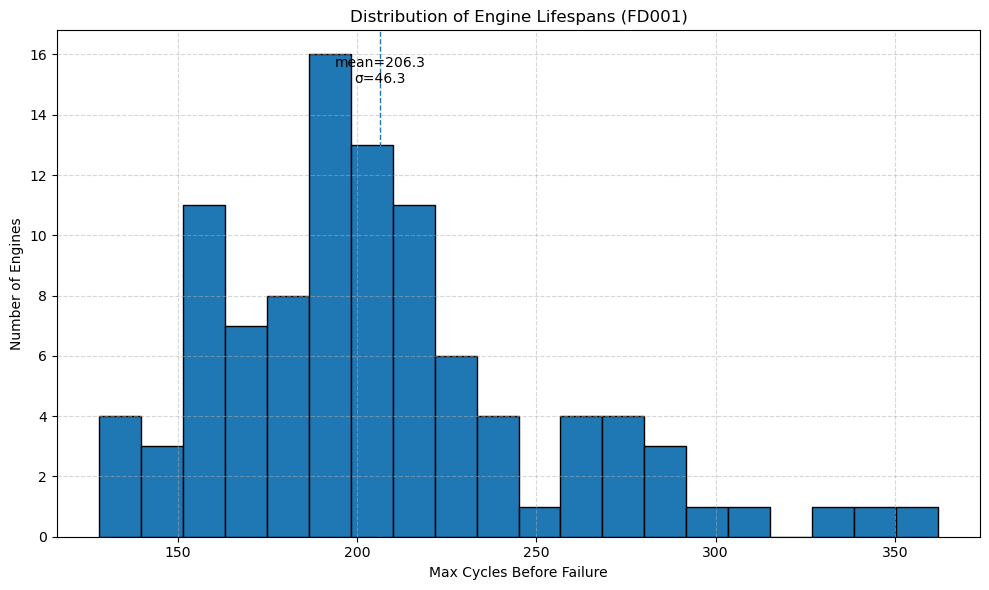

unit_number
39    128
91    135
70    137
57    137
58    147
     ... 
83    293
67    313
96    336
92    341
69    362
Name: time_in_cycles, Length: 100, dtype: int64

In [4]:
plot_engine_lifespan_hist(train_df, dataset_name=DATASET)

In [5]:
import numpy as np

def select_representative_units(df, random_state=42):
    """
    Select representative engine units:
    - Shortest-lived
    - Median-lived
    - Longest-lived
    - One random unit (reproducible with random_state)

    Args:
        df (pd.DataFrame): Engine dataset with 'unit_number' and 'time_in_cycles'.
        random_state (int): Seed for reproducibility.

    Returns:
        list[int]: List of selected engine IDs.
    """
    # Compute max cycles per engine
    lifespans = df.groupby("unit_number")["time_in_cycles"].max().sort_values()

    # Shortest-lived
    shortest = lifespans.index[0]
    # Median-lived
    median = lifespans.index[len(lifespans) // 2]
    # Longest-lived
    longest = lifespans.index[-1]
    # One random
    rng = np.random.default_rng(random_state)
    random_unit = rng.choice(lifespans.index)

    return [shortest, median, longest, int(random_unit)]


Selected engines: [39, 68, 69, 90]


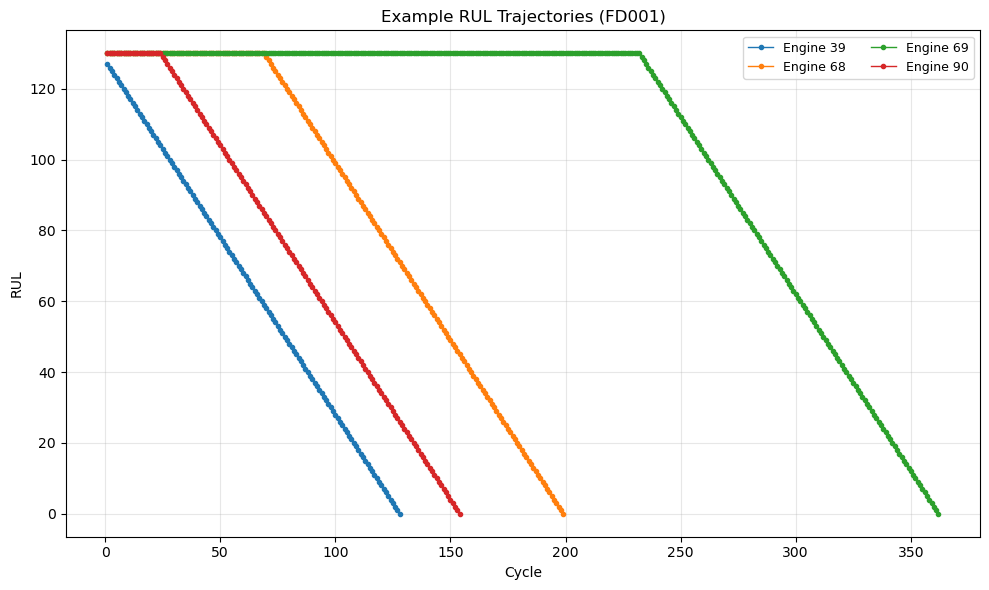

In [6]:
example_units = select_representative_units(train_df, random_state=42)
print("Selected engines:", example_units)

plot_example_rul_trajectories(train_df, unit_ids=example_units,
                              max_rul=MAX_RUL, dataset_name=DATASET)


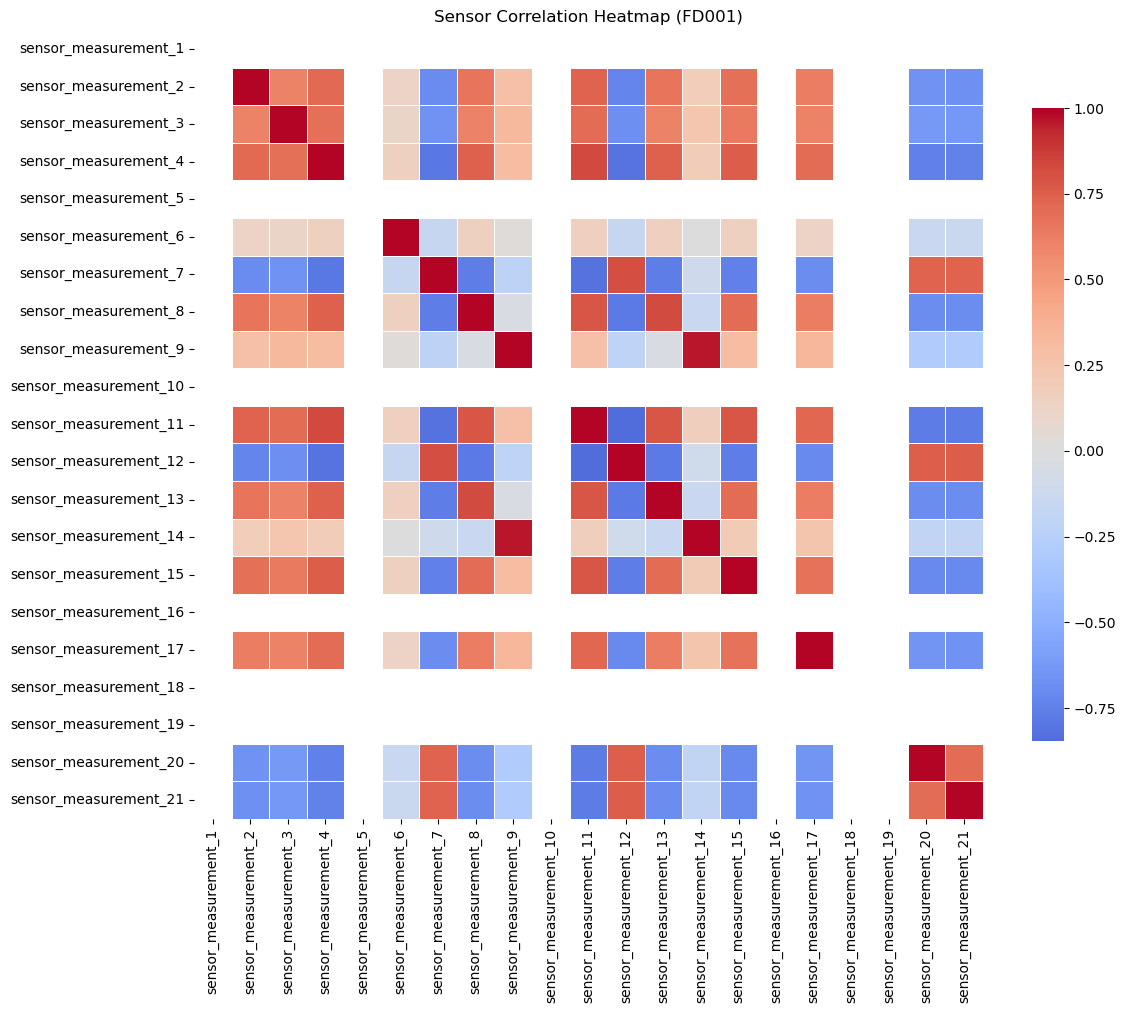

,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
sensor_measurement_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sensor_measurement_2,NaN,1.000000,0.602610,0.714949,NaN,0.132242,-0.702136,0.662325,0.273764,NaN,...,-0.724578,0.661792,0.179752,0.675975,NaN,0.629886,NaN,NaN,-0.661841,-0.668050
sensor_measurement_3,NaN,0.602610,1.000000,0.678413,NaN,0.116039,-0.664595,0.602481,0.322964,NaN,...,-0.680307,0.600963,0.237137,0.639921,NaN,0.600017,NaN,NaN,-0.625941,-0.633901
sensor_measurement_4,NaN,0.714949,0.678413,1.000000,NaN,0.150480,-0.793130,0.746852,0.297429,NaN,...,-0.815591,0.745158,0.190748,0.758459,NaN,0.703499,NaN,NaN,-0.748067,-0.745193
sensor_measurement_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sensor_measurement_6,NaN,0.132242,0.116039,0.150480,NaN,1.000000,-0.155720,0.152161,0.019347,NaN,...,-0.155884,0.158276,-0.002112,0.149042,NaN,0.130810,NaN,NaN,-0.141419,-0.137419
sensor_measurement_7,NaN,-0.702136,-0.664595,-0.793130,NaN,-0.155720,1.000000,-0.767132,-0.217835,NaN,...,0.812713,-0.764611,-0.110053,-0.747051,NaN,-0.692893,NaN,NaN,0.736163,0.737447
sensor_measurement_8,NaN,0.662325,0.602481,0.746852,NaN,0.152161,-0.767132,1.000000,-0.032091,NaN,...,-0.786540,0.826084,-0.144787,0.700949,NaN,0.627785,NaN,NaN,-0.687030,-0.688840
sensor_measurement_9,NaN,0.273764,0.322964,0.297429,NaN,0.019347,-0.217835,-0.032091,1.000000,NaN,...,-0.210238,-0.034763,0.963157,0.293753,NaN,0.337110,NaN,NaN,-0.285280,-0.292795
sensor_measurement_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
plot_sensor_correlation_heatmap(train_df, dataset_name=DATASET)

In [8]:
stats, top_pos, top_neg, corr = summarize_sensor_correlations(train_df, method="pearson", top_k=5)

print("Correlation summary:", {k: round(v, 3) if isinstance(v, float) else v for k, v in stats.items()})

display(top_pos.round(3))
display(top_neg.round(3))

Correlation summary: {'mean_corr': 0.033, 'median_corr': 0.132, 'mean_abs_corr': 0.522, 'median_abs_corr': 0.662, 'n_pairs': 210}


,sensor_a,sensor_b,corr,abs_corr
0,sensor_measurement_9,sensor_measurement_14,0.963,0.963
1,sensor_measurement_4,sensor_measurement_11,0.830,0.830
2,sensor_measurement_8,sensor_measurement_13,0.826,0.826
3,sensor_measurement_7,sensor_measurement_12,0.813,0.813
4,sensor_measurement_8,sensor_measurement_11,0.782,0.782


,sensor_a,sensor_b,corr,abs_corr
0,sensor_measurement_11,sensor_measurement_12,-0.847,0.847
1,sensor_measurement_7,sensor_measurement_11,-0.823,0.823
2,sensor_measurement_4,sensor_measurement_12,-0.816,0.816
3,sensor_measurement_4,sensor_measurement_7,-0.793,0.793
4,sensor_measurement_12,sensor_measurement_13,-0.788,0.788


In [9]:
train__clean = pp.drop_flat_sensors(train_df.copy())

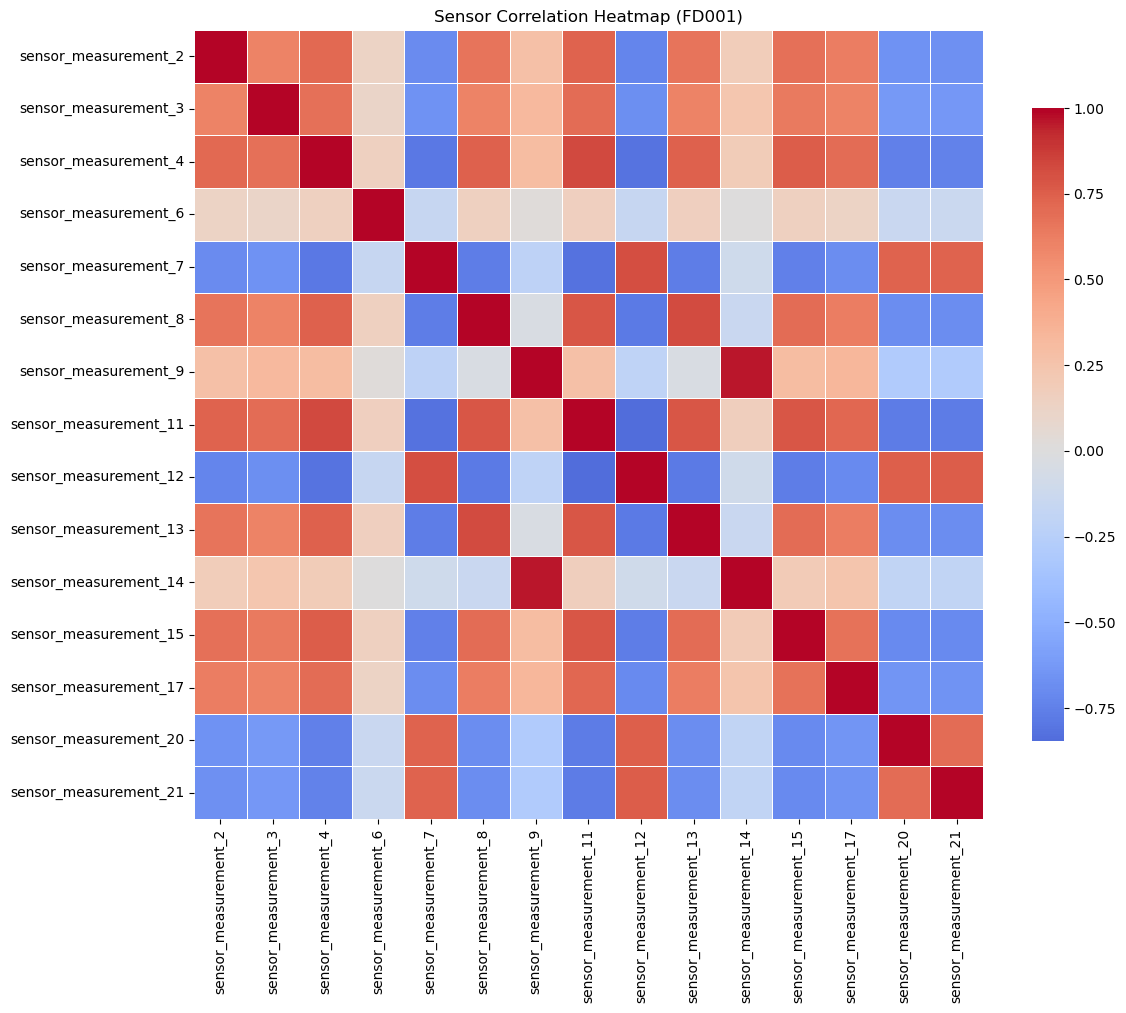

,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21
sensor_measurement_2,1.000000,0.602610,0.714949,0.132242,-0.702136,0.662325,0.273764,0.740020,-0.724578,0.661792,0.179752,0.675975,0.629886,-0.661841,-0.668050
sensor_measurement_3,0.602610,1.000000,0.678413,0.116039,-0.664595,0.602481,0.322964,0.695900,-0.680307,0.600963,0.237137,0.639921,0.600017,-0.625941,-0.633901
sensor_measurement_4,0.714949,0.678413,1.000000,0.150480,-0.793130,0.746852,0.297429,0.830136,-0.815591,0.745158,0.190748,0.758459,0.703499,-0.748067,-0.745193
sensor_measurement_6,0.132242,0.116039,0.150480,1.000000,-0.155720,0.152161,0.019347,0.160014,-0.155884,0.158276,-0.002112,0.149042,0.130810,-0.141419,-0.137419
sensor_measurement_7,-0.702136,-0.664595,-0.793130,-0.155720,1.000000,-0.767132,-0.217835,-0.822805,0.812713,-0.764611,-0.110053,-0.747051,-0.692893,0.736163,0.737447
sensor_measurement_8,0.662325,0.602481,0.746852,0.152161,-0.767132,1.000000,-0.032091,0.782213,-0.786540,0.826084,-0.144787,0.700949,0.627785,-0.687030,-0.688840
sensor_measurement_9,0.273764,0.322964,0.297429,0.019347,-0.217835,-0.032091,1.000000,0.274591,-0.210238,-0.034763,0.963157,0.293753,0.337110,-0.285280,-0.292795
sensor_measurement_11,0.740020,0.695900,0.830136,0.160014,-0.822805,0.782213,0.274591,1.000000,-0.846884,0.780761,0.163408,0.780913,0.722296,-0.771510,-0.772554
sensor_measurement_12,-0.724578,-0.680307,-0.815591,-0.155884,0.812713,-0.786540,-0.210238,-0.846884,1.000000,-0.788441,-0.098141,-0.766052,-0.703485,0.751943,0.756263
sensor_measurement_13,0.661792,0.600963,0.745158,0.158276,-0.764611,0.826084,-0.034763,0.780761,-0.788441,1.000000,-0.147036,0.697662,0.627410,-0.686172,-0.688948


In [10]:
plot_sensor_correlation_heatmap(train__clean, dataset_name=DATASET)

In [11]:
stats, top_pos, top_neg, corr = summarize_sensor_correlations(train__clean, method="pearson", top_k=5)

print("Correlation summary:", {k: round(v, 3) if isinstance(v, float) else v for k, v in stats.items()})

display(top_pos.round(3))
display(top_neg.round(3))

Correlation summary: {'mean_corr': 0.033, 'median_corr': 0.132, 'mean_abs_corr': 0.522, 'median_abs_corr': 0.662, 'n_pairs': 105}


,sensor_a,sensor_b,corr,abs_corr
0,sensor_measurement_9,sensor_measurement_14,0.963,0.963
1,sensor_measurement_4,sensor_measurement_11,0.830,0.830
2,sensor_measurement_8,sensor_measurement_13,0.826,0.826
3,sensor_measurement_7,sensor_measurement_12,0.813,0.813
4,sensor_measurement_8,sensor_measurement_11,0.782,0.782


,sensor_a,sensor_b,corr,abs_corr
0,sensor_measurement_11,sensor_measurement_12,-0.847,0.847
1,sensor_measurement_7,sensor_measurement_11,-0.823,0.823
2,sensor_measurement_4,sensor_measurement_12,-0.816,0.816
3,sensor_measurement_4,sensor_measurement_7,-0.793,0.793
4,sensor_measurement_12,sensor_measurement_13,-0.788,0.788
